### Machine Learning Pipelines 

#### Predicting Vehicle's CO2 Emissions 

### Task Evaluation 

#### Task: Predict how much CO₂ a vehicle will emit based on its characteristics.

What the code did to achieve this task:

1. Gathered Information: It loaded a dataset containing information about different vehicles and their CO₂ emissions.
Organized Information: It prepared the data by separating the vehicle characteristics (like engine size, make, model, etc.) from the CO₂ emission values (the thing we want to predict).
2. Cleaned and Prepared Data: It handled any missing information in the dataset and got the data ready for the prediction model. This involved making sure all the information was in a format the model could understand (like converting text categories into numbers).
3. Built a Predictor: It created a prediction model (using something called a Random Forest Regressor) and set up a process (a pipeline) to automatically prepare new data and feed it to the model.
4. Trained the Predictor: It used a portion of the data to train the model to learn the relationship between vehicle characteristics and CO₂ emissions.
Tested the Predictor: It used a separate portion of the data (that the model hadn't seen before) to see how well it could predict CO₂ emissions.
5. Evaluated Performance: It calculated metrics (like R², RMSE, and MAE) to measure how accurate the model's predictions were.
6. Visualized Results: It created charts (like the scatter plot and correlation heatmap) to help understand the relationships in the data and how well the model performed visually.
7. Saved the Predictor: It saved the trained model so it can be used later to predict CO₂ emissions for new vehicles.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import joblib

In [84]:
data= pd.read_csv("vehicle_emissions.csv")

In [85]:
# Separate features (X) and target variable (y)
X = data.drop(['CO2_Emissions'], axis=1)
y = data['CO2_Emissions']

In [86]:
data.shape 

(935, 12)

In [87]:
data.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_comb(L/100km),CO2_Emissions,Smog_Level
0,2021,Acura,ILX,Compact,2.4,4,AM8,9.9,7.0,8.6,199,3
1,2021,Acura,NSX,Two-seater,3.5,6,AM9,11.1,10.8,11.0,256,3
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,11.0,8.6,9.9,232,6
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,11.3,9.1,10.3,242,6
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,AS10,11.2,8.0,9.8,230,7


In [88]:
#Handle missing values this way or simply using the imputer 
def fill_missing():
    # handling all missing values.
    for col in data.columns:
        # missing values in numerical columns are replaced with mean
        if data[col].dtype == float:
            mean=data[col].mean()
            data[col]= data[col].fillna(mean)
        # missing values in discrete columns are replaced with median
        if data[col].dtype == int:
            median=data[col].median()
            data[col]= data[col].fillna(median)
        # missing values in categorical columns are replaced with mode
        if data[col].dtype == object:
            mode=data[col].mode().iloc[0]
            data[col]= data[col].fillna(mode)
    return data
data=fill_missing()

In [89]:
data.isnull().sum()

Model_Year                                0
Make                                      0
Model                                     0
Vehicle_Class                             0
Engine_Size                               0
Cylinders                                 0
Transmission                              0
Fuel_Consumption_in_City(L/100 km)        0
Fuel_Consumption_in_City_Hwy(L/100 km)    0
Fuel_Consumption_comb(L/100km)            0
CO2_Emissions                             0
Smog_Level                                0
dtype: int64

In [90]:
data.info 

<bound method DataFrame.info of      Model_Year   Make              Model  Vehicle_Class  Engine_Size  \
0          2021  Acura                ILX        Compact          2.4   
1          2021  Acura                NSX     Two-seater          3.5   
2          2021  Acura         RDX SH-AWD     SUV: Small          2.0   
3          2021  Acura  RDX SH-AWD A-SPEC     SUV: Small          2.0   
4          2021  Acura         TLX SH-AWD        Compact          2.0   
..          ...    ...                ...            ...          ...   
930        2021  Volvo        XC40 T5 AWD     SUV: Small          2.0   
931        2021  Volvo        XC60 T5 AWD     SUV: Small          2.0   
932        2021  Volvo        XC60 T6 AWD     SUV: Small          2.0   
933        2021  Volvo        XC90 T5 AWD  SUV: Standard          2.0   
934        2021  Volvo        XC90 T6 AWD  SUV: Standard          2.0   

     Cylinders Transmission  Fuel_Consumption_in_City(L/100 km)  \
0            4          

In [91]:
data.dtypes 

Model_Year                                  int64
Make                                       object
Model                                      object
Vehicle_Class                              object
Engine_Size                               float64
Cylinders                                   int64
Transmission                               object
Fuel_Consumption_in_City(L/100 km)        float64
Fuel_Consumption_in_City_Hwy(L/100 km)    float64
Fuel_Consumption_comb(L/100km)            float64
CO2_Emissions                               int64
Smog_Level                                  int64
dtype: object

In [92]:
def rename_feature(data,column_mapping):
    # This function changes names of columns
    # It takes two inputs: data and a dictionary where keys are old column names and values are new column names.
    return data.rename(columns=column_mapping,inplace=True)

In [93]:
def sep_col(data):
    # this function separates categorical and numerical columns of our data.
    categorical_columns = data.select_dtypes(include=['object']).columns
    numerical_columns = data.select_dtypes(exclude=['object']).columns.drop('CO2_Emissions')
    return categorical_columns,numerical_columns

categorical_columns,numerical_columns=sep_col(data)

In [94]:
categorical_columns

Index(['Make', 'Model', 'Vehicle_Class', 'Transmission'], dtype='object')

In [95]:
numerical_columns 

Index(['Model_Year', 'Engine_Size', 'Cylinders',
       'Fuel_Consumption_in_City(L/100 km)',
       'Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_comb(L/100km)', 'Smog_Level'],
      dtype='object')

In [96]:
# Pipeline for preprocessing numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [97]:
# Pipeline for preprocessing categorical data
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [98]:
# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns), 
    ('cat', categorical_pipeline, categorical_columns) 
])

In [99]:
# Final pipeline that includes preprocessing and the machine learning model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())  # Default parameters are used; can be tuned for better performance
])

In [100]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Train and predict Model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [101]:
# Print the shape of training and testing datasets for verification
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(pd.DataFrame(X_train).head())

Training data shape: (748, 11)
Test data shape: (187, 11)
     Model_Year    Make                     Model Vehicle_Class  Engine_Size  \
408        2021     GMC               Terrain AWD    SUV: Small          1.5   
5          2021   Acura         TLX SH-AWD A-SPEC       Compact          2.0   
54         2021    Audi     SQ5 Sportback quattro    SUV: Small          3.0   
275        2021    Ford  Bronco Black Diamond 4WD    SUV: Small          2.3   
868        2021  Toyota         Camry AWD XLE/XSE      Mid-size          2.5   

     Cylinders Transmission  Fuel_Consumption_in_City(L/100 km)  \
408          4           A9                                 9.6   
5            4         AS10                                11.3   
54           6          AS8                                13.1   
275          4         AS10                                13.1   
868          4          AS8                                 9.5   

     Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumpt

In [103]:
# Get the names of encoded categorical columns
# This is useful for interpreting the transformed feature set
encoded_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(categorical_columns)
print(encoded_columns)

['Make_Acura' 'Make_Alfa Romeo' 'Make_Aston Martin' 'Make_Audi' 'Make_BMW'
 'Make_Bentley' 'Make_Bugatti' 'Make_Buick' 'Make_Cadillac'
 'Make_Chevrolet' 'Make_Chrysler' 'Make_Dodge' 'Make_FIAT' 'Make_Ford'
 'Make_GMC' 'Make_Genesis' 'Make_Honda' 'Make_Hyundai' 'Make_Infiniti'
 'Make_Jaguar' 'Make_Jeep' 'Make_Kia' 'Make_Lamborghini' 'Make_Lexus'
 'Make_Lincoln' 'Make_MINI' 'Make_Maserati' 'Make_Mazda'
 'Make_Mercedes-Benz' 'Make_Mitsubishi' 'Make_Nissan' 'Make_Porsche'
 'Make_Ram' 'Make_Rolls-Royce' 'Make_Subaru' 'Make_Toyota'
 'Make_Volkswagen' 'Make_Volvo' 'Model_1500' 'Model_1500 4X4 EcoDiesel'
 'Model_1500 4X4 TRX' 'Model_1500 4X4 eTorque' 'Model_1500 Classic'
 'Model_1500 Classic 4X4' 'Model_1500 EcoDiesel'
 'Model_1500 HFE EcoDiesel' 'Model_1500 HFE eTorque' 'Model_1500 eTorque'
 'Model_228i xDrive Gran Coupe' 'Model_230i xDrive Coupe' 'Model_300'
 'Model_300 AWD' 'Model_430i xDrive Coupe' 'Model_4Runner 4WD'
 'Model_4Runner 4WD (Part-Time 4WD)' 'Model_500X AWD'
 'Model_530i xDriv

In [104]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root mean squared error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [105]:
print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.4f}")  # Higher is better; 1.0 indicates perfect prediction
print(f"Root Mean Squared Error: {rmse:.2f}")  # Lower is better
print(f"Mean Absolute Error: {mae:.2f}")  # Lower is better


Model Performance Metrics:
R² Score: 0.9741
Root Mean Squared Error: 10.20
Mean Absolute Error: 3.22


In [106]:
joblib.dump(pipeline, 'vehicle_emissions_pipeline.joblib')

['vehicle_emissions_pipeline.joblib']

In [107]:
metrics = ['R²', 'RMSE', 'MAE']
values = [r2, rmse, mae]

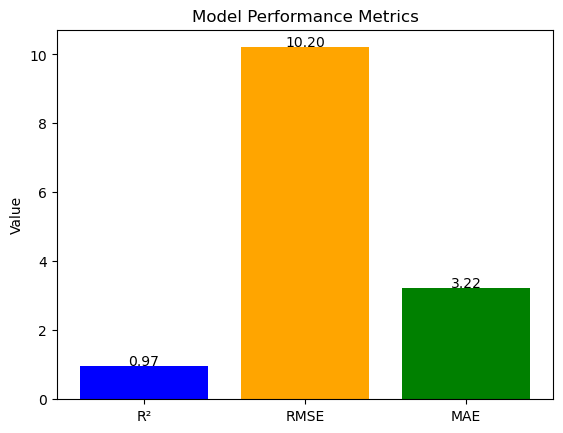

In [108]:
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title('Model Performance Metrics')
plt.ylabel('Value')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

### Analysis of Calculated Evaluation Metrics

The code successfully built and trained a model to predict CO₂ emissions. The performance metrics (R² of 0.9749, RMSE of 10.05, and MAE of 3.24) and the scatter plot indicate that the model is very good at predicting CO₂ emissions based on the provided data.

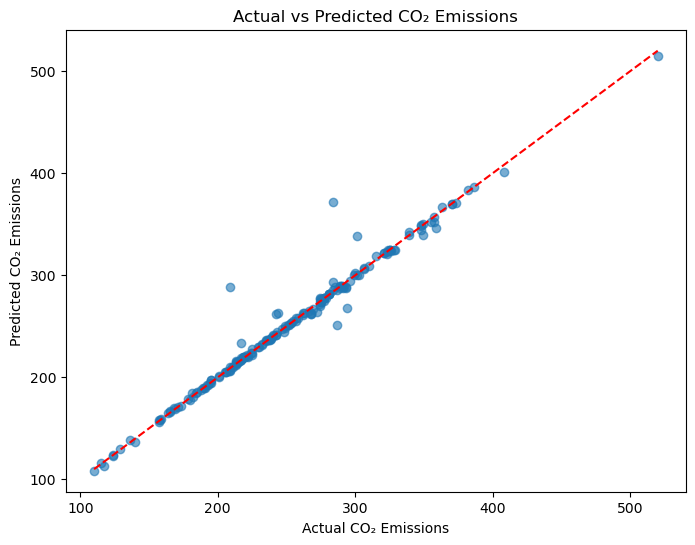

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted CO₂ Emissions')
plt.xlabel('Actual CO₂ Emissions')
plt.ylabel('Predicted CO₂ Emissions')
plt.show()

### Scatter Plot Summarised 

The scatter plot you generated shows the relationship between the actual CO₂ emissions from your test dataset and the CO₂ emissions predicted by your trained model.

Here's what it's showing:
Each point represents a vehicle from your test set.
The x-axis shows the actual CO₂ emissions for that vehicle.
The y-axis shows the CO₂ emissions predicted by your model for the same vehicle.
The red dashed line represents the ideal scenario where predicted emissions exactly equal actual emissions.
Ideally, for a well-performing model, the points should cluster closely around the red dashed line. The closer the points are to this line, the more accurate your model's predictions are.

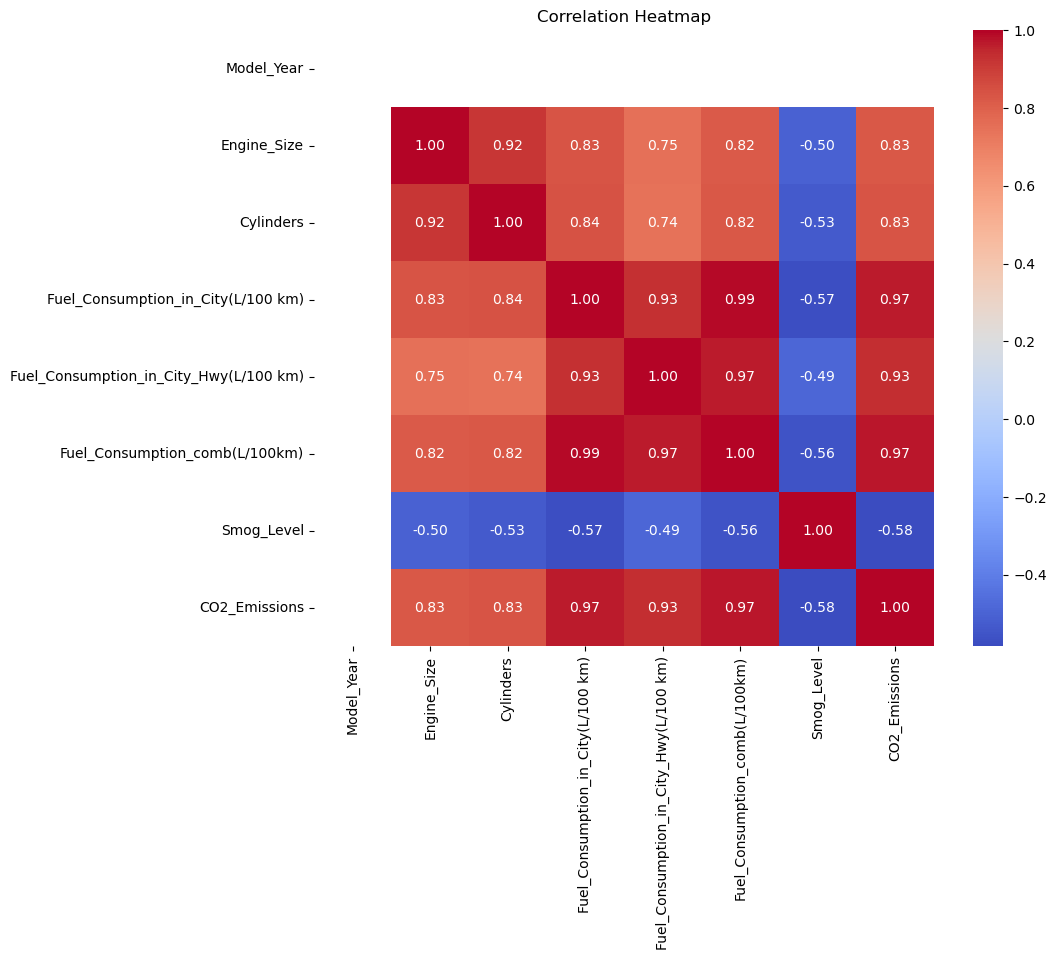

In [112]:
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

# Exclude the target variable from the list of predictors for correlation calculation
if 'CO2_Emissions' in numerical_columns:
    numerical_columns.remove('CO2_Emissions')

corr_matrix = data[numerical_columns + ['CO2_Emissions']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### General Insights From Correlation Matrix/Heatmap 

Based on the correlation heatmap, here are a few insights:

1. Strong positive correlations with CO₂ Emissions: 'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_comb(L/100km)', 'Fuel_Consumption_in_City_Hwy(L/100 km)', 'Engine_Size', and 'Cylinders' show strong positive correlations with 'CO2_Emissions'. This indicates that as these values increase, CO₂ emissions tend to increase as well.
2. Strongest correlation with CO₂ Emissions: 'Fuel_Consumption_in_City(L/100 km)' and 'Fuel_Consumption_comb(L/100km)' have the highest positive correlation with 'CO2_Emissions' (around 0.96-0.99), which is expected as fuel consumption is directly related to emissions.
3. Negative correlation with Smog Level: 'Smog_Level' shows a moderate negative correlation with 'CO2_Emissions' (around -0.58). This suggests that vehicles with higher smog levels tend to have lower CO₂ emissions, and vice versa. This might seem counterintuitive and could be an interesting point for further investigation or indicate that different regulations or technologies affect these two metrics differently.
4. Strong correlations among fuel consumption metrics: The three fuel consumption columns ('Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_in_City_Hwy(L/100 km)', and 'Fuel_Consumption_comb(L/100km)') are highly correlated with each other, which is expected as they all measure fuel efficiency.
5. Correlation between Engine Size and Cylinders: 'Engine_Size' and 'Cylinders' are strongly positively correlated (around 0.92), which is also expected as larger engines typically have more cylinders.
6. Model Year: 'Model_Year' appears to have NaN values in the correlation matrix, suggesting there might be no variation in the 'Model_Year' column in the dataset, or it's not being treated as a numerical variable correctly for correlation calculation. (Looking back at the data, it appears 'Model_Year' is indeed all 2021).

## In short, the code did a great job of tackling the task of predicting vehicle CO₂ emissions!